In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load pre-saved datasets
train_df_save_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/data/train_df.csv"
test_df_save_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/data/test_df.csv"

train_df = pd.read_csv(train_df_save_path)
test_df = pd.read_csv(test_df_save_path)


Mounted at /content/drive


Step 3: Model Architecture 
1. It will take 28 hours to run with batch size 8 and max length 128 and 13 hours to run with batch size 8 and max length 128. Google Collab can be disconnected after an app runs over 10 hours, so we need to lower it to batch size 8 and max length 32.

2. Tokenizer & Model:

    DistilBERT-base-uncased is used as the pre-trained model.
    The tokenizer processes text into tokenized inputs with a maximum sequence length of 32 to fit within memory constraints.
3. Dataset Preparation:

    The dataset is tokenized and converted into a PyTorch-friendly format.
    A custom PyTorch dataset class is created to load tokenized inputs and labels.
    The test set is split into validation and test subsets (80% test, 20% validation).
  

 4. Training Configuration & Optimization:

    Batch size of 8 (smaller to prevent crashes due to memory limits).
    Learning rate: 2×10^-5, with a linear learning rate scheduler.
    Weight decay: 0.01 to reduce overfitting.
    Gradient accumulation: Steps set to 8 to simulate a larger batch size.
    Evaluation and saving strategy: After every epoch.
    Best model selection: The best-performing model based on accuracy is automatically loaded at the end.

5. Improvements with Early Stopping & Epochs

    Early Stopping: Implemented with EarlyStoppingCallback(early_stopping_patience=2), meaning if the validation accuracy does not improve for two consecutive epochs, training stops early. This prevents overfitting and saves time.
    Epochs: Initially set to 5, allowing sufficient learning while avoiding unnecessary training cycles if early stopping triggers.
    
    Evaluation Strategy: The model is evaluated after each epoch, ensuring real-time performance tracking and stopping early if no progress is observed.
    
6. By using early stopping, the model prevents unnecessary training on a saturated learning curve, optimizing both accuracy and training efficiency. A lower batch size ensures stable execution on CPU, while gradient accumulation compensates for it, effectively increasing the batch size without overwhelming memory. These refinements enhance generalization and model robustness without excessive training.


In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

train_reviews = train_df['Cleaned_sentence'].tolist()
train_targets = train_df['sentiment'].tolist()
test_reviews = test_df['Cleaned_sentence'].tolist()
test_targets = test_df['sentiment'].tolist()

x_val, x_test, y_val, y_test = train_test_split(test_reviews, test_targets, test_size=0.8, stratify=test_targets)

max_length = 32

train_encodings = tokenizer(train_reviews, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(x_val, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=max_length)

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Create a dictionary where each key corresponds to an input feature
        # and its value is converted into a PyTorch tensor for the given index.
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        # Add the label for the corresponding index, also as a PyTorch tensor
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_targets)
val_dataset = SentimentDataset(val_encodings, y_val)
test_dataset = SentimentDataset(test_encodings, y_test)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/results",
    run_name="sentiment_analysis",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    metric_for_best_model="accuracy",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    num_train_epochs=5,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=8,
    weight_decay=0.01,
    report_to="none"
)


def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score
    # Unpack logits (model outputs) and labels from the evaluation prediction tuple
    logits, labels = eval_pred
    # Convert logits to class predictions by selecting the index with the highest value
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    print(f"Epoch Accuracy: {acc:.4f}")
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()



In [ ]:
# Google Collab commands
# !pip list | grep -E "torch|transformers"
# !pip install --upgrade torch torchvision transformers


Step 4: Results and Analysis
1. The following test ran on CPU. It crashed if processing over 25% of testing data. To provide mixed data, it checked the first 12.5% of the positive reviews and the first 12.5% of negative reviews.
2. The above training returned 4 epochs. The inference time and accuracy are measured for each checkpoint, and classification reports, confusion matrices, and memory usage statistics are generated. Themodel accuracy ranges between 0.7565 and 0.7677 and the inference time ranges between 314 seconds to 324 seconds. The average inference time is 318.99 and the average accuracy is 76.25. The last checkpoint has a slightly better accuracy.

Checkpoint 1

    Accuracy: 0.7564
    Confusion Matrix:
        True Negatives (0 correctly predicted as 0): 2,187 (69.98% of actual 0s)
        False Positives (0 incorrectly predicted as 1): 938
        False Negatives (1 incorrectly predicted as 0): 584
        True Positives (1 correctly predicted as 1): 2,541 (81.31% of actual 1s)

Checkpoint 2

    Accuracy: 0.7670
    Confusion Matrix:
        True Negatives (0 correctly predicted as 0): 2,392 (76.50% of actual 0s)
        False Positives (0 incorrectly predicted as 1): 733
        False Negatives (1 incorrectly predicted as 0): 723
        True Positives (1 correctly predicted as 1): 2,402 (76.86% of actual 1s)

Checkpoint 3

    Accuracy: 0.7630
    Confusion Matrix:
        True Negatives (0 correctly predicted as 0): 2,153 (68.89% of actual 0s)
        False Positives (0 incorrectly predicted as 1): 972
        False Negatives (1 incorrectly predicted as 0): 509
        True Positives (1 correctly predicted as 1): 2,616 (83.71% of actual 1s)

Checkpoint 4

    Accuracy: 0.7676
    Confusion Matrix:
        True Negatives (0 correctly predicted as 0): 2,329 (74.53% of actual 0s)
        False Positives (0 incorrectly predicted as 1): 796
        False Negatives (1 incorrectly predicted as 0): 656
        True Positives (1 correctly predicted as 1): 2,469 (79.01% of actual 1s)


The model is better at identifying positive sentiment than negative sentiment across all checkpoints.

Checkpoint 4 provides the best balance between precision and recall while achieving the highest accuracy.

Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU cores available: 2
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

PyTorch Inference Time: 315.39 sec
PyTorch Model Accuracy: 0.7565
Classification Report:
               precision    recall  f1-score   support

           0     0.7892    0.6998    0.7419      3125
           1     0.7304    0.8131    0.7695      3125

    accuracy                         0.7565      6250
   macro avg     0.7598    0.7565    0.7557      6250
weighted avg     0.7598    0.7565    0.7557      6250



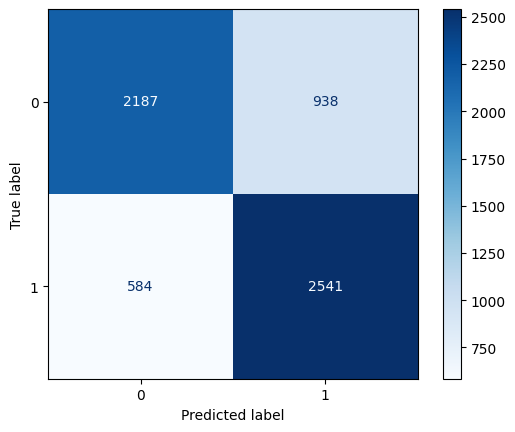

PyTorch Inference Time: 324.39 sec
PyTorch Model Accuracy: 0.7670
Classification Report:
               precision    recall  f1-score   support

           0     0.7679    0.7654    0.7667      3125
           1     0.7662    0.7686    0.7674      3125

    accuracy                         0.7670      6250
   macro avg     0.7670    0.7670    0.7670      6250
weighted avg     0.7670    0.7670    0.7670      6250



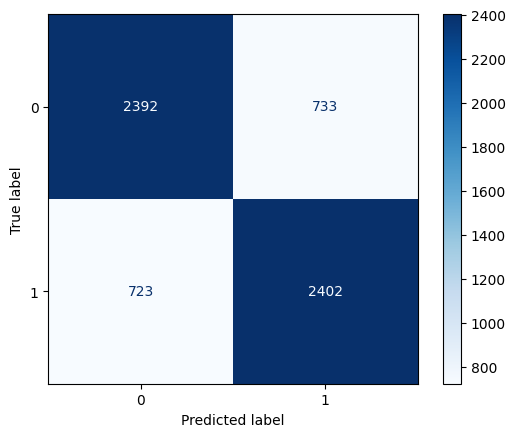

PyTorch Inference Time: 314.91 sec
PyTorch Model Accuracy: 0.7630
Classification Report:
               precision    recall  f1-score   support

           0     0.8088    0.6890    0.7441      3125
           1     0.7291    0.8371    0.7794      3125

    accuracy                         0.7630      6250
   macro avg     0.7689    0.7630    0.7617      6250
weighted avg     0.7689    0.7630    0.7617      6250



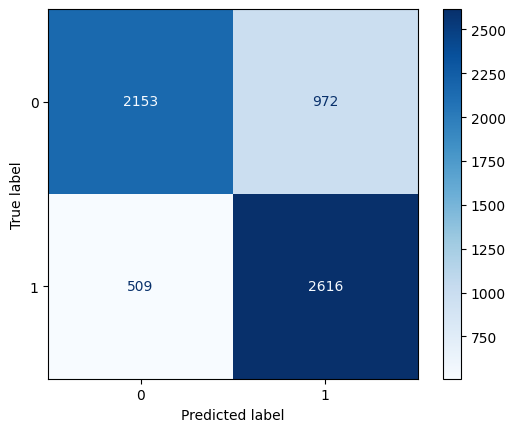

PyTorch Inference Time: 321.27 sec
PyTorch Model Accuracy: 0.7677
Classification Report:
               precision    recall  f1-score   support

           0     0.7802    0.7453    0.7624      3125
           1     0.7562    0.7901    0.7728      3125

    accuracy                         0.7677      6250
   macro avg     0.7682    0.7677    0.7676      6250
weighted avg     0.7682    0.7677    0.7676      6250



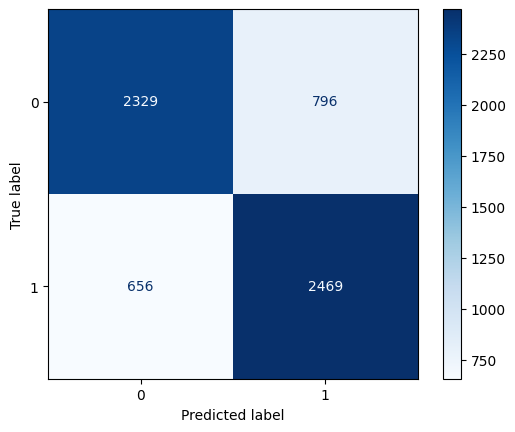


Performance Results:
PyTorch Accuracy 1: 0.7564799785614014
PyTorch Inference Time: 321.27065992355347
PyTorch Accuracy 2: 0.7670400142669678
PyTorch Accuracy 3: 0.7630400061607361
PyTorch Accuracy 4: 0.7676799893379211


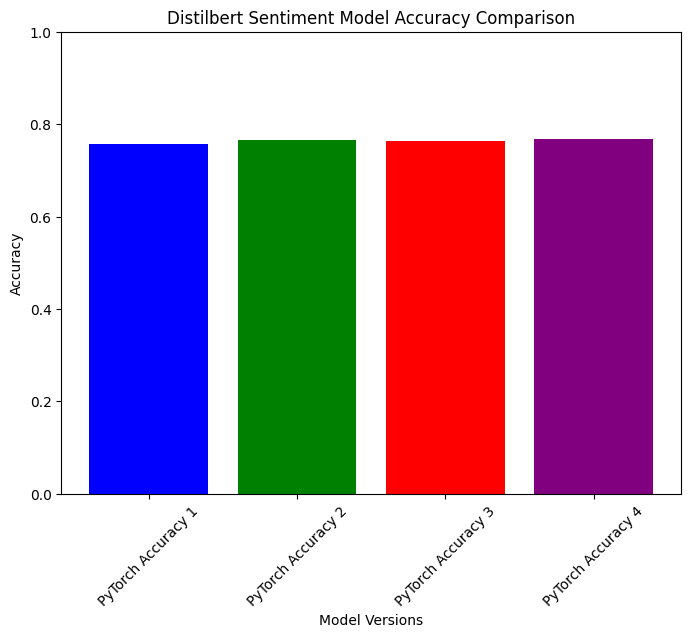

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from safetensors.torch import load_file
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing

# Google Collab commands
# !lscpu |grep 'Model name'
# !lscpu | grep 'MHz'
print("CPU cores available:", multiprocessing.cpu_count())

# Define device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Prepare Test Data
first_12_5_percent = test_df.iloc[:int(0.125 * len(test_df))]
last_12_5_percent = test_df.iloc[int(0.875 * len(test_df)):]
selected_data = pd.concat([first_12_5_percent, last_12_5_percent])
test_reviews = selected_data['Cleaned_sentence'].tolist()
test_targets = selected_data['sentiment'].tolist()
test_labels = torch.tensor(test_targets)

def tokenize_data_pt(texts, max_length=32):
    """
    Tokenizes input text for a PyTorch BERT model.

    Args:
        texts (list of str): List of input text samples to be tokenized.
        max_length (int, optional): Maximum tokenized sequence length (default: 32).

    Returns:
        torch.Tensor: Tokenized output as tensors moved to the specified device (e.g., GPU/CPU).
    """
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

def load_pytorch_model(model_path):
    model = DistilBertForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
    state_dict = load_file(f"{model_path}/model.safetensors")
    model.load_state_dict(state_dict)
    model.to(device)  # Move model to CPU/GPU
    model.eval()
    return model

def evaluate_pytorch(model, test_reviews, test_targets):
    inputs = tokenize_data_pt(test_reviews)
    test_labels = torch.tensor(test_targets).to(device)  # Ensure labels are on the same device

    # Measure Inference Time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()

    predictions = torch.argmax(outputs.logits, dim=1)

    # Accuracy Calculation
    accuracy = (predictions == test_labels).float().mean().item()
    inference_time = end_time - start_time

    print(f"PyTorch Inference Time: {inference_time:.2f} sec")
    print(f"PyTorch Model Accuracy: {accuracy:.4f}")

    # Classification Report & Confusion Matrix
    report = classification_report(test_targets, predictions.cpu().numpy(), digits=4)
    print("Classification Report:\n", report)

    cm = confusion_matrix(test_targets, predictions.cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.show()

    # GPU Memory Usage
    if torch.cuda.is_available():
        print(f"GPU Memory Used: {torch.cuda.memory_allocated(device) / 1e6:.2f} MB")

    return accuracy, inference_time

# Load Model Path
pytorch_1_model_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/results/checkpoint-391"
pytorch_2_model_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/results/checkpoint-782"
pytorch_3_model_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/results/checkpoint-1173"
pytorch_4_model_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/results/checkpoint-1564"
pytorch_model_1 = load_pytorch_model(pytorch_1_model_path)
pytorch_model_2 = load_pytorch_model(pytorch_2_model_path)
pytorch_model_3 = load_pytorch_model(pytorch_3_model_path)
pytorch_model_4 = load_pytorch_model(pytorch_4_model_path)

# Get Accuracy & Time
pytorch_accuracy_1, pytorch_inference_time_1 = evaluate_pytorch(pytorch_model_1, test_reviews, test_targets)
pytorch_accuracy_2, pytorch_inference_time_2 = evaluate_pytorch(pytorch_model_2, test_reviews, test_targets)
pytorch_accuracy_3, pytorch_inference_time_3 = evaluate_pytorch(pytorch_model_3, test_reviews, test_targets)
pytorch_accuracy_4, pytorch_inference_time_4 = evaluate_pytorch(pytorch_model_4, test_reviews, test_targets)
# Store Results for Comparison
performance_results = {
    "PyTorch Accuracy 1": pytorch_accuracy_1,
    "PyTorch Inference Time": pytorch_inference_time_1,
    "PyTorch Accuracy 2": pytorch_accuracy_2,
    "PyTorch Inference Time": pytorch_inference_time_2,
    "PyTorch Accuracy 3": pytorch_accuracy_3,
    "PyTorch Inference Time": pytorch_inference_time_3,
    "PyTorch Accuracy 4": pytorch_accuracy_4,
    "PyTorch Inference Time": pytorch_inference_time_4
}

print("\nPerformance Results:")
for key, value in performance_results.items():
    print(f"{key}: {value}")

# Plot Accuracy Comparison
labels = [
    "PyTorch Accuracy 1",
    "PyTorch Accuracy 2",
    "PyTorch Accuracy 3",
    "PyTorch Accuracy 4"
]

accuracies = [
    pytorch_accuracy_1,
    pytorch_accuracy_2,
    pytorch_accuracy_3,
    pytorch_accuracy_4
]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.xlabel("Model Versions")
plt.ylabel("Accuracy")
plt.title("Distilbert Sentiment Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()
